In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as T
from torchvision.models import ResNet, resnet18, resnet50
from PIL import Image

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier

In [3]:
img_preprocess = T.Compose([
            # We use single int value inside a list due to torchscript type restrictions
            T.Resize([256, ]),
            T.CenterCrop(224),
            T.ConvertImageDtype(torch.float),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
class ResnetPredictor(nn.Module):

    def __init__(self, model: ResNet):
        super().__init__()
        self.model = model
        self.transforms = img_preprocess

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            x = self.transforms(x)
            _ = self.model(x)
            y_pred: torch.Tensor = nn.Softmax(dim=1)(_).topk(5)
            clazz = y_pred.values.clone().detach().cpu().tolist()
            confs = y_pred.indices.clone().detach().cpu().tolist()
            # topk = y_pred.topk(5)
            return clazz, confs

In [15]:
r18 = resnet18(pretrained=True, progress=True).eval().cuda()
r50 = resnet50(pretrained=True, progress=True).eval().cuda()
model_version_mapping = {
    50: r50,
    18: r18
}


In [ ]:
pil_image = Image.open("./imgs/dogs.jpg")
if pil_image.mode == 'RGBA':
    pil_image = pil_image.convert('RGB')
img = img_preprocess(T.ToTensor()(pil_image)).cuda()
img

In [ ]:
predictor = ResnetPredictor(r50).to(0)
res = predictor(img.unsqueeze_(0))

In [47]:
res

([[0.999515175819397,
   0.00024377662339247763,
   0.0001022979777189903,
   6.603808287763968e-05,
   2.5767878469196148e-05]],
 [[818, 506, 971, 968, 421]])

In [6]:
import torch.optim as optim

def getClassifier(model):
   criterion = nn.CrossEntropyLoss()
   optimizer = optim.Adam(model.parameters(), lr=0.01)
   classifier = PyTorchClassifier(
        model=model,
        clip_values=(0, 1),
        loss=criterion,
        optimizer=optimizer,
        input_shape=(3, 224, 224),
        nb_classes=1000,
        )
   return classifier

In [8]:
torch.save(r18, "./resnet18.pkl")


In [20]:
# 这里相当于是加载第三方上传的模型
r18 = torch.load("./resnet18.pkl")

In [10]:
r18
# 可以读取第三方上传的模型的所有信息

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:

classifier = getClassifier(r18)

In [22]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    attack = FastGradientMethod(estimator=classifier, eps=0.6)

In [29]:
import numpy as np
x:np.ndarray = img.unsqueeze_(0).clone().detach().cpu().numpy()

In [30]:
x.shape

(1, 3, 224, 224)

In [31]:
adv = attack.generate(x)
# 并且可以进行白盒攻击

In [32]:
import kornia
kornia_img = kornia.enhance.denormalize(torch.Tensor(adv), torch.Tensor([0.485, 0.456, 0.406]).unsqueeze_(0), torch.tensor([0.229, 0.224, 0.225]).unsqueeze_(0))


D:\app\Miniconda3\envs\adv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
D:\app\Miniconda3\envs\adv\lib\site-packages\ipykernel\pylab\config.py:70: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


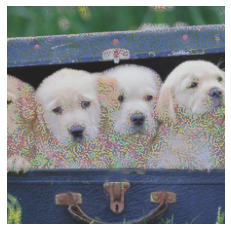

In [33]:
# adv = adv[0]
a = kornia_img.numpy()[0]
# print(a)
import matplotlib.pyplot as plt
import numpy as np
plt.figure()
plt.axis("off")
plt.imshow(a.transpose(1,2,0))
plt.show()

In [56]:
predictor = ResnetPredictor(r50).to(0)
res = predictor(kornia_img.cuda())

D:\app\Miniconda3\envs\adv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
res

D:\app\Miniconda3\envs\adv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


([[0.8273826837539673,
   0.040224142372608185,
   0.032656654715538025,
   0.02755838818848133,
   0.00962915737181902]],
 [[257, 222, 229, 216, 208]])

In [33]:
np.version.version

D:\app\Miniconda3\envs\adv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'1.20.2'